In [599]:
import numpy as np
import matplotlib.pyplot as plt

In [600]:
T = 2 * np.pi
n = 1000
h = T / n

Q = np.array([[10, 0, 0],[0, 5, 0],[0, 0, 5]])
R = np.array([[1, 0],[0, 1]])
P_1 = np.array([[0, 0, 0],[0, 0, 0],[0, 0, 0]]) # no terminal cost

# Goal Trajectory
x_g = np.zeros((n,3))
for i in range(n):
    x_g[i,0] = 2*h*i/np.pi
    x_g[i,2] = np.pi/2

In [601]:
# Dynamics
def dynamics(x0, u):
    x = np.zeros((n,3))
    x[0] = x0
    for i in range(n-1):
        x[i+1,2] = x[i,2] + h*u[i,1]
        x[i+1,0] = x[i,0] + h*np.cos(x[i,2])*u[i,0]
        x[i+1,1] = x[i,1] + h*np.sin(x[i,2])*u[i,0]
    return x

In [602]:
# Cost Function
def J(x, u):
    intg = 0
    for i in range(n):
        intg += h*(np.dot(np.dot((x[i] - x_g[i]).T, Q), (x[i]-x_g[i])) + np.dot(np.dot(u[i].T, R), u[i]))
    return intg

# Cost Function Directional Derivative
def DJ(x, u, zeta):
    intg = 0
    for i in range(n):
        intg += h*2*(np.dot(np.dot((x[i] - x_g[i]).T, Q), zeta[i, :3]) + np.dot(np.dot(u[i].T, R), zeta[i, 3:]))
    return intg

In [603]:
# Get zeta
def get_zeta(x, u):
    # (a.T, b.T) = D l(x, u) = (2(x-x_g).T Q, 2u.T R) 
    # A(t) = D1 f(x,u)
    # B(t) = D2 f(x,u)
    A = np.zeros((n,3,3)) # Time, Matrix
    B = np.zeros((n,3,2)) # Time, Matrix
    for i in range(n):
        A[i] = [[0, 0, -np.sin(x[i,2])*u[i,0]], [0, 0, np.cos(x[i,2])*u[i,0]], [0, 0, 0]]
        B[i] = [[np.cos(x[i,2]), 0], [np.sin(x[i,2]), 0], [0, 1]] 

    zeta = np.zeros((n,5))
    P = np.zeros((n,3,3)) # Time, Matrix
    r = np.zeros((n,3)) # Time, Vector
    P[n-1] = [[0, 0, 0],[0, 0, 0],[0, 0, 0]] # no terminal cost
    r[n-1] = [0, 0, 0] #no terminal cost

    i = n-1
    while i > 0:
        P_dot = -np.dot(P[i], A[i]) - np.dot(A[i].T, P[i]) + np.dot(np.dot(np.dot(np.dot(P[i], B[i]), np.linalg.inv(R)), B[i].T), P[i]) - Q
        r_dot = np.dot(np.dot(np.dot(P[i], B[i]), np.linalg.inv(R)), 2*np.dot(u[i].T, R).T) - 2*np.dot((x[i] - x_g[i]).T, Q).T - np.dot((A[i] - np.dot(np.dot(np.dot(B[i], np.linalg.inv(R)), B[i].T), P[i])).T, r[i])
        P[i-1] = P[i] - h*P_dot
        r[i-1] = r[i] - h*r_dot
        
        i -= 1

    zeta[0, :3] = [0, 0, 0]
    for i in range(n-1):
        zeta[i, 3:] = -np.dot(np.dot(np.dot(np.linalg.inv(R), B[i].T), P[i]), zeta[i, :3]) - np.dot(np.dot(np.linalg.inv(R), B[i].T), r[i]) - np.dot(np.linalg.inv(R), 2*np.dot(u[i].T, R).T)
        zeta[i+1, :3] += h*(np.dot(A[i], zeta[i, :3]) + np.dot(B[i], zeta[i, 3:]))
    return zeta

In [604]:
# Initial Trajectory
x0 = [0,0,np.pi/2]
u_init = np.zeros((n,2))
for i in range(n-1):
    u_init[i] = [1, -0.5]
x_init = dynamics(x0, u_init)

# Initial Cost
#J_init = J(x_init, u_init)
#print(J_init)

In [605]:
# iLQR
eps = 0.01 # Threshold

u_iLQR = u_init
x_iLQR = x_init

zeta = np.zeros((n,5)) # zeta = [z0, z1, z2, v0, v1]

i = 0
while i==0 or np.abs(DJ(x_iLQR, u_iLQR, zeta)) > eps:
    print(np.abs(DJ(x_iLQR, u_iLQR, zeta)))
    # zeta = argmin(DJ(u)*zeta) + 0.5*np.dot(zeta.T, zeta)
    zeta = get_zeta(x_iLQR, u_iLQR)
    
    # Armijo
    alpha = 0.01
    beta = 0.5
    gamma = 1
    J_u = J(x_iLQR, u_iLQR)
    DJ_u_zeta = DJ(x_iLQR, u_iLQR, zeta)
    while J(dynamics(x0, u_iLQR + gamma*zeta[:, 3:]), u_iLQR + gamma*zeta[:, 3:]) > J_u + alpha*gamma*DJ_u_zeta:
        #print(J(dynamics(x0, u_iLQR + gamma*zeta[:, 3:]), u_iLQR + gamma*zeta[:, 3:]))
        gamma *= beta

    # Update u, x for all times
    for j in range(n):
        u_iLQR[j] += gamma*zeta[j, 3:]
    x_iLQR = dynamics(x0, u_iLQR)
    i += 1


0.0
59.655282094449724
74.31142270829663
74.44544677133567
74.3265363903851
73.92609136275989
73.22672843206762
69.1455606612605
60.335347681308676
14.594753013694131
86.0387985121511
16.526942119581822
33.29488298017321
32.576630544612314
22.161523441150923
31.897418025884196
70.16141637889368
4.97641186760717
27.98831438754958
36.79655938957436
1.6805985297868615
2.294065039255836
53.04176455731106
32.04272698318123
9.419829297326764
14.258693804394937
3.2654676851457283
3.4455208191653166
6.257028782502446
0.8445404523275081
5.648921306122687
7.621894417157093
6.939728735611141
1.3429858018281433
2.5151105205661817
1.9485468938931512
2.670971921608607
2.539333337735339
2.0955395980802902
2.3781362760629774
2.8509291414109077
2.6742972469632598
2.1484682536066457
2.8437595038382315
1.8374680065467055
1.517941409285775
1.2484634068716083
1.985870073146816
1.5998075383985566
1.5670078431935532
2.2747420170198063
1.497719926369378
0.7624489725295605
0.6285762354741412
0.7721872239437388

Text(0.5, 0.98, 'Optimized Controls')

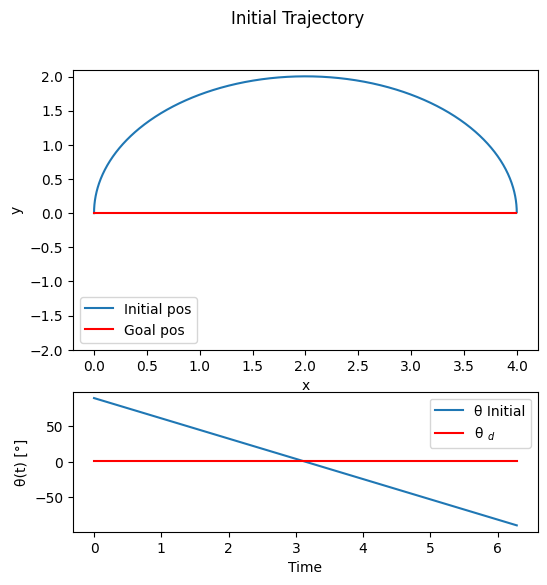

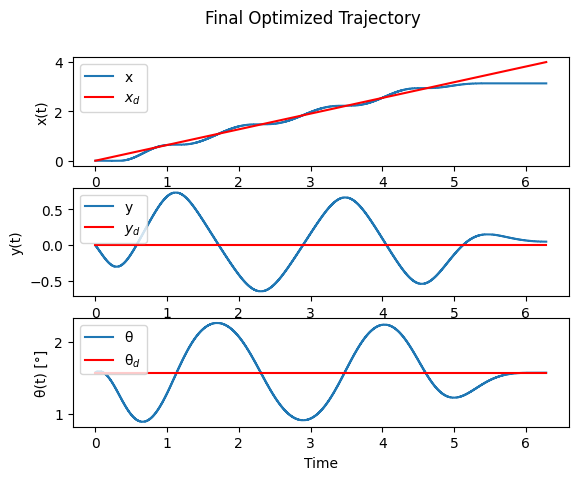

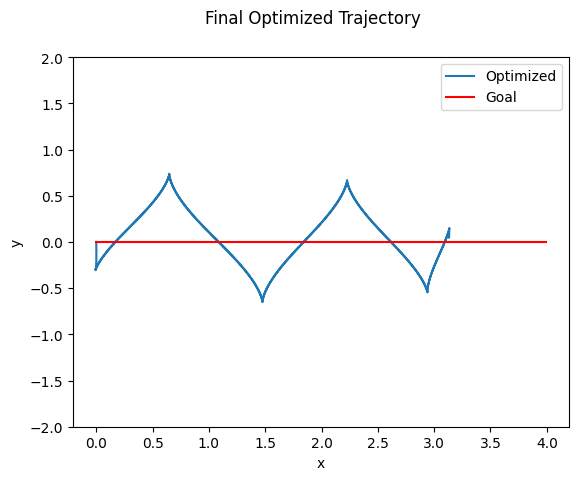

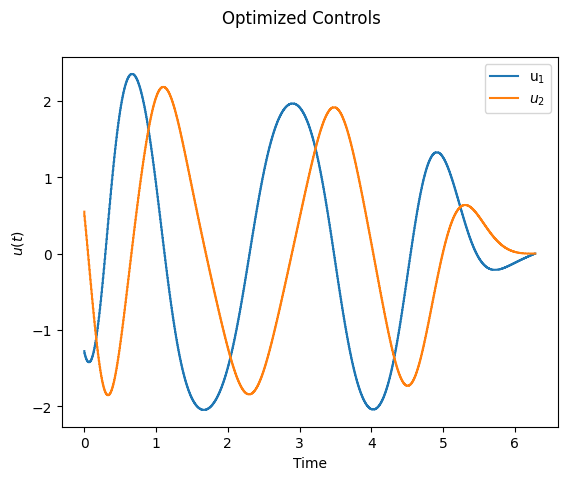

In [606]:
# Plots: Initial Trajectory, Final Optimized Trajectory, Optimized Control Signal
time_discr = np.linspace(0, T, n)

#Plot Initial Trajectory
fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[2, 1], figsize=(6, 6))
ax1.plot(x_init[:,0], x_init[:,1], label='Initial pos')
ax1.plot(x_g[:,0], x_g[:,1], color='red', label='Goal pos')
ax2.plot(time_discr, x_init[:,2]*180/np.pi, label="\u03B8 Initial")
ax2.plot(time_discr, x_g[:,2], color='red', label="\u03B8 $_{d}$")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_ylim([-2, 2.1])
ax2.set_xlabel("Time")
ax2.set_ylabel("\u03B8(t) [°]")
ax1.legend()
ax2.legend()
fig.suptitle("Initial Trajectory")
#plt.savefig('ME455_ActiveLearning/HW2/HW2_1_init_traj.png')

#Plots Final Optimized Trajectory
fig2, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.step(time_discr, x_iLQR[:,0], label="x")
ax2.step(time_discr, x_iLQR[:,1], label="y")
ax1.plot(time_discr, x_g[:,0], color='red', label=r"$x_{d}$")
ax2.plot(time_discr, x_g[:,1], color='red', label=r"$y_{d}$")
ax3.step(time_discr, x_iLQR[:,2], label="\u03B8")
ax3.plot(time_discr, x_g[:,2], color='red', label="\u03B8$_{d}$")
ax1.set_xlabel("Time")
ax1.set_ylabel("x(t)")
ax2.set_xlabel("Time")
ax2.set_ylabel("y(t)")
ax3.set_xlabel("Time")
ax3.set_ylabel("\u03B8(t) [°]")
ax1.legend()
ax2.legend()
ax3.legend()
fig2.suptitle("Final Optimized Trajectory")
#plt.savefig('ME455_ActiveLearning/HW2/HW2_1_opt_time.png')

fig3, ax = plt.subplots()
ax.step(x_iLQR[:,0], x_iLQR[:,1], label='Optimized')
ax.plot(x_g[:,0], x_g[:,1], color='red', label='Goal')
ax.legend()
ax.set_ylim([-2, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
fig3.suptitle("Final Optimized Trajectory")
#plt.savefig('ME455_ActiveLearning/HW2/HW2_1_opt_xy.png')

# Plot Optimized Control Signal
fig4, ax = plt.subplots()
ax.step(time_discr, u_iLQR[:,0], label=r"u$_{1}$")
ax.step(time_discr, u_iLQR[:,1], label=r"$u_{2}$")
ax.legend(loc='upper right')
ax.set_xlabel("Time")
ax.set_ylabel(r"$u(t)$")
fig4.suptitle("Optimized Controls")
#plt.savefig('ME455_ActiveLearning/HW2/HW2_1_opt_u.png')